In [59]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt

%run diagnostics.ipynb

In [3]:
cols_to_drop = ['timestamp', 'lexeme_id', 'word', 'user_id', 'avg_user_p_recall', 'ui_language', 'learning_language']
current_dir = os.getcwd()
filename = 'df_processed.csv'
filepath = os.path.normpath(os.path.join(current_dir, '../data/processed/', filename))

chunk_size = 10000
chunks = []

for chunk in pd.read_csv(filepath, chunksize=chunk_size):
    chunk.drop_duplicates(inplace=True)
    chunk.dropna(inplace=True)
    chunks.append(chunk)


# Join dataframes 
df_processed = pd.concat(chunks, ignore_index=True)
df_users = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'users_behaviur.csv')))
df_words = pd.read_csv(os.path.normpath(os.path.join(current_dir, '../data/features/', 'word_complexity_features.csv')), sep='\t')
df = pd.merge(pd.merge(df_words, df_processed, on = 'lexeme_id', how='inner'), df_users, on = ['user_id', 'lang_combination'], how='inner')

df.drop(columns=cols_to_drop, inplace=True, errors='ignore')

In [6]:
df_words

,lexeme_id,gender,def,tense,POS,person,number,word,word_len,tags_list,SUBTLEX
0,76390c1350a8dac31186187e2fe1e178,NaN,NaN,pri,vblex,p3,sg,lernt,5,"['vblex', 'pri', 'p3', 'sg']",3391.0
1,7dfd7086f3671685e2cf1c1da72796d7,f,def,NaN,det,NaN,sg,die,3,"['det', 'def', 'f', 'sg']",2484854.0
2,35a54c25a2cda8127343f6a82e6f6b7d,m,NaN,NaN,n,NaN,sg,mann,4,"['n', 'm', 'sg']",222707.0
3,0cf63ffe3dda158bc3dbd55682b355ae,f,NaN,NaN,n,NaN,sg,frau,4,"['n', 'f', 'sg']",143725.0
4,84920990d78044db53c1b012f5bf9ab5,nt,def,NaN,det,NaN,sg,das,3,"['det', 'def', 'nt', 'sg']",3122198.0
...,...,...,...,...,...,...,...,...,...,...,...
19263,289ec4ae458f4741f9401eb234dd29a3,NaN,NaN,prs,vblex,NaN,NaN,acontecer,9,"['vblex', 'prs']",66924.0
19264,6633292d640dda65f2160fcf2bbb0e2d,NaN,NaN,prs,vblex,NaN,NaN,pegar,5,"['vblex', 'prs']",12910.0
19265,832551ca2353cc290409e0a61a1e8f5a,f,NaN,NaN,n,NaN,NaN,gara,4,"['n', 'f']",10084.0
19266,551a67d04615085738d178e5a8432dc3,nt,NaN,NaN,n,NaN,NaN,feld,4,"['n', 'nt']",3661.0


In [4]:
df.head()

,gender,def,tense,POS,person,number,word_len,tags_list,SUBTLEX,p_recall,delta,history_seen,history_correct,session_seen,session_correct,h_recall,lang_combination,avg_delta,std_delta,avg_h_recall
0,NaN,NaN,pri,vblex,p3,sg,5,"['vblex', 'pri', 'p3', 'sg']",3391.0,1.0,27649635,6,4,2,2,0.666667,en-de,6.245869e+06,1.175043e+07,0.884367
1,NaN,NaN,pri,vblex,p3,sg,5,"['vblex', 'pri', 'p3', 'sg']",3391.0,1.0,5963,8,6,6,6,0.750000,en-de,6.245869e+06,1.175043e+07,0.884367
2,NaN,NaN,pri,vblex,p3,sg,5,"['vblex', 'pri', 'p3', 'sg']",3391.0,0.0,253,14,12,1,0,0.857143,en-de,6.245869e+06,1.175043e+07,0.884367
3,NaN,NaN,pri,vblex,p3,sg,5,"['vblex', 'pri', 'p3', 'sg']",3391.0,1.0,65,15,12,1,1,0.800000,en-de,6.245869e+06,1.175043e+07,0.884367
4,NaN,NaN,pri,vblex,p3,sg,5,"['vblex', 'pri', 'p3', 'sg']",3391.0,0.5,27,16,13,2,1,0.812500,en-de,6.245869e+06,1.175043e+07,0.884367


In [7]:
# Handle tags 
# 1) Store tags as list, but delete rows where there are less than x occurences 
# tag_counts = df['tags_list'].value_counts()
# rare_threshold = 1000
# df['tags_list'] = df['tags_list'].apply(lambda x: x if tag_counts[x] > rare_threshold else 'rare')

# df.drop(columns=['POS', 'person', 'number', 'gender', 'tense', 'def'], inplace=True)
# df.dropna(inplace=True)


# 2) Store each tag as column, replace NaN values with a placeholder for categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
df[categorical_cols] = df[categorical_cols].fillna('missing')
df.drop(columns=['tags_list'], inplace=True)

In [12]:
# VIF -> see which columns have VIF > 10 
# def calculate_vif(X):
#     vif_data = pd.DataFrame()
#     vif_data["Feature"] = X.columns
#     vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#     return vif_data
    
# dff_VIF = df.drop(columns=['p_recall','history_correct', 'history_seen']).sample(2000000)
# vif = calculate_vif(dff_VIF.select_dtypes(exclude='O'))
# vif

# Remove columns with high VIF
# removed_features = ["avg_h_recall", 'history_correct']
# correlation_with_target = dff_1[removed_features + ["p_recall"]].corr()["p_recall"]
# print(correlation_with_target)

In [13]:
# Take sample
dff_final = df.sample(frac=1)

In [14]:
# Transforming skewed variables
# dff_final['history_wrong'] = np.log2(1+(dff_final['history_seen']-dff_final['history_correct']))
# dff['SUBTLEX'] = np.log2(dff['SUBTLEX'])

dff_final['delta'] = np.log2(dff_final['delta']/(60*60*24))
dff_final['avg_delta'] = np.log2(dff_final['avg_delta']/(60*60*24))
dff_final['history_seen'] = np.log2(1+dff_final['history_seen'])
dff_final['history_correct'] = np.log2(1+dff_final['history_correct'])


In [16]:
dff_final[['word_len', 'SUBTLEX', 'delta', 'history_seen', 'history_correct', 'h_recall', 'std_delta', 'avg_h_recall', 'avg_delta', 'p_recall']].corr()['p_recall'].sort_values()

delta             -0.045686
avg_delta         -0.031136
std_delta         -0.024063
SUBTLEX           -0.010736
history_seen      -0.003085
history_correct    0.013024
word_len           0.014453
h_recall           0.102244
avg_h_recall       0.162237
p_recall           1.000000
Name: p_recall, dtype: float64

In [17]:
# Transformation of target variable 

# Logit transformation 
def logit_transform(y, epsilon=1e-10):
    y = np.clip(y, epsilon, 1 - epsilon)
    return np.log(y / (1 - y))

def inverse_logit_transform(y):
    return 1 / (1 + np.exp(-y))


# Log transformation 
def log_transform(y, epsilon=1e-10):
    return np.log(y + epsilon)

def inverse_log_transform(y):
    return np.exp(y)
    

# Box-Cox transformation
power_transformer = PowerTransformer(method='box-cox', standardize=False)
def power_transform(y, epsilon=1e-10):
    return power_transformer.fit_transform(y+epsilon) 

def inverse_power_transform(y, epsilon=1e-10):
    return power_transformer.inverse_transform(y+epsilon) 

In [20]:
# Create variants of dataframe

# Create df without word features 
# dff_t = dff_final.drop(columns=['tags_list', 'word_len', 'SUBTLEX'], errors='ignore')

# df without SUBTLEX
# dff_t = dff_final.drop(columns=['SUBTLEX'], errors='ignore')

# DF original 
# dff_s = dff_final.drop(columns=['SUBTLEX', 'tags_list', 'word_len', 'avg_delta', 'std_delta', 'avg_h_recall', 'lang_combination', 'h_recall'], errors='ignore')

# DF without history correct and seen
# dff_s = dff_final.drop(columns=['history_correct', 'history_seen'], errors='ignore')

# DF without user columns 
# dff_u = dff_final.drop(columns=['avg_delta', 'std_delta', 'avg_h_recall', 'h_recall'], errors='ignore')

# DF without lang ui and lang native
# dff_u = dff_final.drop(columns=['ui_language', 'learning_language'], errors='ignore')


In [21]:
def ohe(df):
    """
    One-hot encode categorical variables
    """ 
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    ohe = OneHotEncoder(sparse_output=False)
    ohe_data = ohe.fit_transform(df[categorical_cols])
    ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(categorical_cols))
    df_encoded = pd.concat([df.select_dtypes(exclude='O'), ohe_df], axis=1)
    df_encoded.dropna(inplace=True)
    return df_encoded

In [22]:
def split_dataset(df):
    X = df.drop(columns='p_recall')
    y = df['p_recall']
    X_train, X_test, y_train, y_test = sklearn_train_test_split(X,
                                                        y,
                                                        train_size=0.8,
                                                        random_state=42)
    
    X_test_session = X_test[['session_seen', 'session_correct']]

    X_test.drop(columns=['session_seen', 'session_correct'], inplace=True)
    X_train.drop(columns=['session_seen', 'session_correct'], inplace=True)

    return X_train, X_test, y_train, y_test, X_test_session

In [23]:
dff_encoded = ohe(dff_final)
# dff_t_encoded = ohe(dff_t)
# dff_s_encoded = ohe(dff_s)
# dff_u_encoded = ohe(dff_u)


X_train, X_test, y_train, y_test, X_test_session = split_dataset(dff_encoded)
# X_train_t, X_test_t, y_train_t, y_test_t = split_dataset(dff_t_encoded)
# X_train_s, X_test_s, y_train_s, y_test_s = split_dataset(dff_s_encoded)
# X_train_u, X_test_u, y_train_u, y_test_u = split_dataset(dff_u_encoded)

In [24]:
def create_pipeline(model_type="linear"):
    """
    Create a pipeline for regression with optional feature selection.
    
    Returns:
    - Pipeline object
    """
    if model_type == "ridge":
        model = Ridge(alpha=0.1, fit_intercept=True)
    else:
        model = LinearRegression()

    steps = [
        ('scaler', StandardScaler()),
        # ('polynomial_features', PolynomialFeatures(degree=3, include_bias=False)),
        ('model', model)
        # ('model', TransformedTargetRegressor(regressor=model, 
        #                                     func=log_transform,
        #                                     inverse_func=inverse_log_transform))
    ]
    return Pipeline(steps)

In [25]:
def train_predict(pipeline, X_train, X_test, y_train, y_test):
    pipeline.fit(X_train, y_train)

    y_train_pred = cap_y(pipeline.predict(X_train))
    y_test_pred = cap_y(pipeline.predict(X_test)) 

    return y_train_pred, y_test_pred

In [30]:
# Define Configurations for Pipelines
def regression_results(X_train, X_test, y_train, y_test, importance=True):
    
    pipeline = create_pipeline()
    y_train_pred, y_test_pred = train_predict(pipeline, X_train, X_test, y_train, y_test)
    
    # Calculate metrics 
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    print(f" Train MAE = {round(train_mae,4)}, Test MAE = {round(test_mae, 4)}")

    
    if importance:
        model = pipeline.named_steps["model"]
        coefficients_df = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': model.coef_})

    print('Intercept:', model.intercept_)
    
    full_df = X_test.copy()
    full_df['predictions'] = y_test_pred
    full_df['p_recall'] = y_test

    return coefficients_df, full_df

In [31]:
print('Results for all features')
coefficients_df, full_df = regression_results(X_train, X_test, y_train, y_test)

# print('Results after deleting word features')
# results_t, importance_t, full_df_t = regression_results(pipelines_config, X_train_t, X_test_t, y_train_t, y_test_t, importance='Yes')

# print('Results without word and user features')
# results_s, importance_s, full_df_s  = regression_results(pipelines_config, X_train_s, X_test_s, y_train_s, y_test_s, importance='Yes')

# print('Results without user features') 
# results_u, importance_u, full_df_u = regression_results(pipelines_config, X_train_u, X_test_u, y_train_u, y_test_u, importance='No')

Results for all features
 Train MAE = 0.1673, Test MAE = 0.1673
Intercept: 0.8965720912013158


In [32]:
# Examine coefficients  
def out_filepath(filename):
    return os.path.normpath(os.path.join(current_dir, '../reports', filename))
    
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)
coefficients_df['Coefficient'] = round(coefficients_df['Coefficient'], 6)

Text(0.5, 1.0, 'Linear Regression residuals histogram')

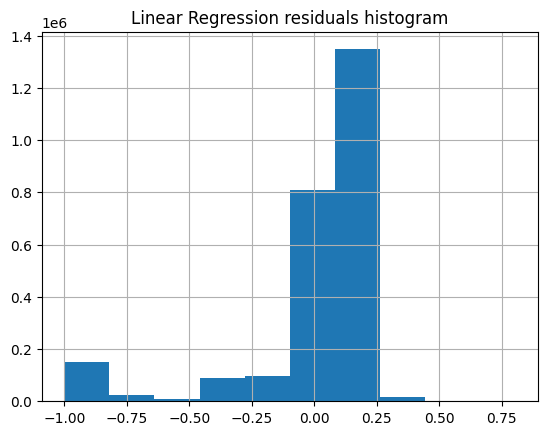

In [33]:
# Examine residuals 
full_df['diff'] = full_df['p_recall'] - full_df['predictions']
resiuals_plot = full_df['diff'].hist()
plt.title('Linear Regression residuals histogram')

Text(0.5, 1.0, 'Predicted vs. Actual Recall Probability')

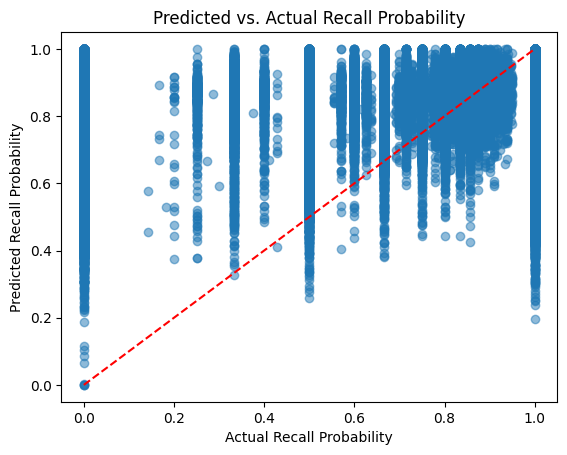

In [45]:
# Predictions vs actual recall probabilities 
predictions_scatterplot = plt.scatter(full_df['p_recall'], full_df['predictions'], alpha=0.5)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("Actual Recall Probability")
plt.ylabel("Predicted Recall Probability")
plt.title("Predicted vs. Actual Recall Probability")

In [46]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)

full_df[['p_recall', 'predictions']].describe()

,p_recall,predictions
count,2540622.00000,2540622.00000
mean,0.89650,0.89660
std,0.27085,0.04879
min,0.00000,0.00000
25%,1.00000,0.87615
50%,1.00000,0.90327
75%,1.00000,0.92650
max,1.00000,1.00000


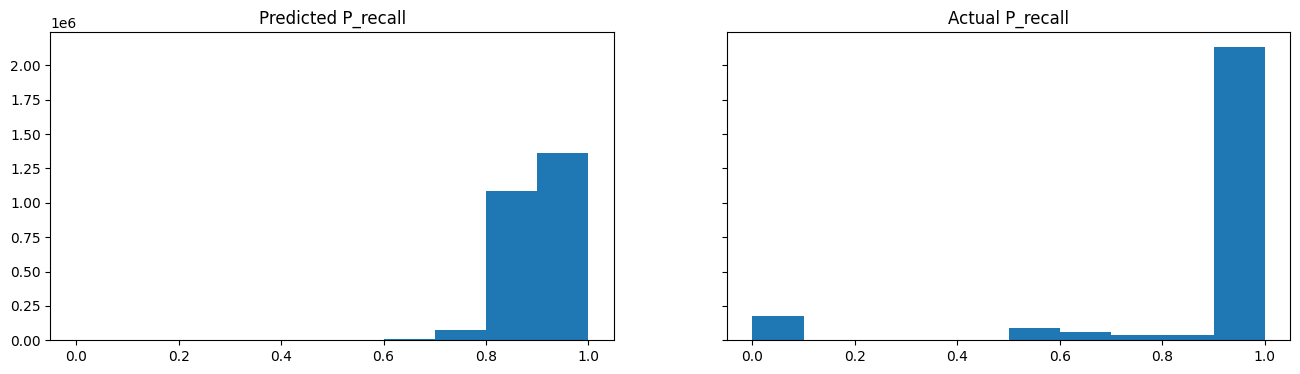

In [47]:
p_recall_histogram, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title('Predicted P_recall')
ax2.hist(full_df['p_recall'])
ax2.set_title('Actual P_recall')
ax1.hist(full_df['predictions'])
p_recall_histogram.set_size_inches(16, 4)

In [48]:
pd.set_option('mode.chained_assignment', None)

results = full_df[['predictions', 'p_recall']]
results['session_seen'] = X_test_session['session_seen']
results['session_correct'] = X_test_session['session_correct']

In [50]:
results

,predictions,p_recall,session_seen,session_correct
11674352,0.76526,0.00000,1,0
383103,0.87250,1.00000,1,1
12456784,0.94681,1.00000,1,1
2853094,0.89060,1.00000,1,1
293322,0.86081,1.00000,5,5
...,...,...,...,...
3614355,0.80786,1.00000,2,2
8781119,0.83216,0.00000,1,0
8610634,0.90855,1.00000,1,1
11518707,0.92036,1.00000,1,1


In [51]:
expanded_df = results.loc[results.index.repeat(results["session_seen"])].reset_index(drop=True)
expanded_df["outcome"] = np.concatenate([
    np.concatenate([np.ones(int(c)), np.zeros(int(s - c))])  # c correct, (s-c) incorrect
    for s, c in zip(results["session_seen"], results["session_correct"])
])

In [57]:
linear_regression_output = expanded_df.drop(columns=['session_seen', 'session_correct'])

filepath = os.path.normpath(os.path.join(current_dir, '../results/'))
linear_regression_output.to_csv(os.path.join(filepath, 'linear_regression_output.csv'), sep='\t', index=False, header=True)

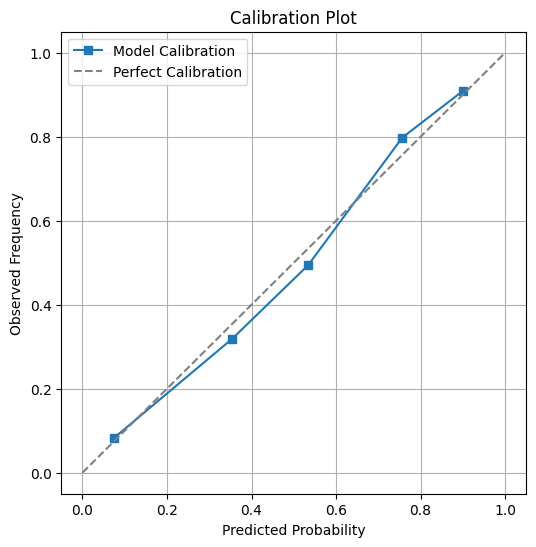

In [58]:
plot_calibration(expanded_df['outcome'], expanded_df['predictions'], 'LR_calibration_plot.png')

AUC Score: 0.6158


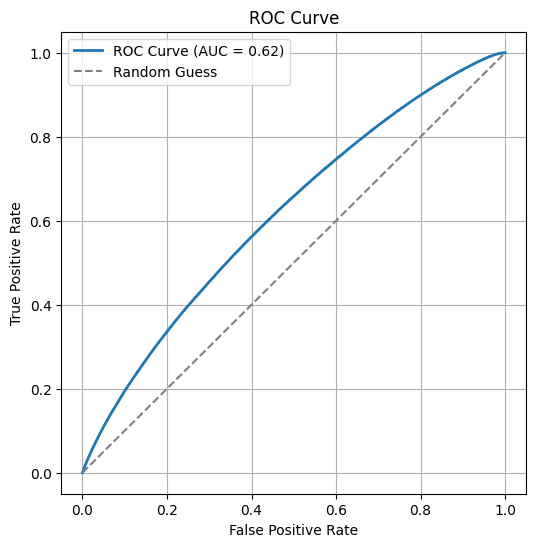

In [54]:
AUC_ROC(expanded_df['outcome'], expanded_df['predictions'], 'LR_ROC_plot.png')

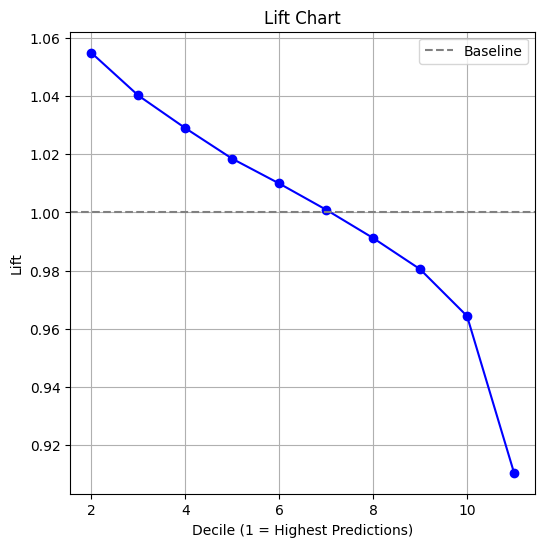

In [63]:
plot_lift(expanded_df, 'outcome', expanded_df['predictions'], 'LR_lift_plot.png')

In [67]:
# # Save to file all charts
coefficients_df.to_csv(out_filepath('LR_coefficients.txt'), sep='\t')
resiuals_plot.savefig(out_filepath('visualizations/LR_residuals_hist.png'))
predictions_scatterplot.savefig(out_filepath('visualizations/LR_predictions_scatterplot.png'))
p_recall_histogram.savefig('visualizations/LR_recall_histograms.png')